In [48]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

sns.set(color_codes=True)
sns.set(style="ticks")

data_frame = pd.read_csv("movie_metadata.csv")
data_frame.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,521.0,147.0,0.0,789.0,Joel David Moore,834.0,4035.0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",...,945.0,English,USA,PG-13,421.0,84.0,841.0,62.0,10.0,781
1,Color,Gore Verbinski,301.0,138.0,348.0,886.0,Orlando Bloom,867.0,3985.0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",...,838.0,English,USA,PG-13,427.0,82.0,894.0,54.0,16.0,0
2,Color,Sam Mendes,503.0,117.0,0.0,160.0,Rory Kinnear,844.0,3880.0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,775.0,English,UK,PG-13,422.0,90.0,377.0,51.0,16.0,831
3,Color,Christopher Nolan,528.0,133.0,433.0,905.0,Christian Bale,860.0,4027.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,936.0,English,USA,PG-13,423.0,87.0,912.0,68.0,16.0,867
4,NaN,Doug Walker,0.0,0.0,127.0,0.0,Rob Walker,120.0,0.0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,0.0,NaN,NaN,NaN,0.0,0.0,11.0,54.0,0.0,0


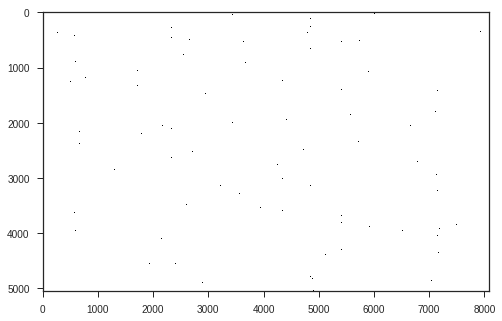

In [49]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder

for column_name in data_frame.columns:
    le = LabelEncoder()
    column = data_frame[column_name]
    if column.dtype == 'object':
        if column_name == 'plot_keywords' or column_name == 'genres':
            mlb = MultiLabelBinarizer()
            keywords = list()
            column.fillna('UNKNOWN')
            column.apply(lambda x: keywords.append(x.split('|')) if x is not np.nan else keywords.append(['UNKNOWN']))
            binarized = mlb.fit_transform(keywords)
            plt.imshow(binarized)
            class_values = pd.Series(list(binarized))
            data_frame[column_name].update(class_values)
    else:
        normalized_column = column.fillna(0) if column.dtype.kind in 'biufc' else column.fillna('UNKNOWN')

        class_values = pd.Series(list(le.fit_transform(normalized_column)))
        data_frame[column_name].update(class_values)

data_frame.head()

In [ ]:
# Figures for representing some features
sns.set(font_scale = 2)
g = sns.jointplot('gross', 'imdb_score', size=12, data=data_frame, kind="kde", color="#10275F")
plt.subplots_adjust(top=10.95)
g.fig.suptitle('KDE of Imdb_Score and Gross', size=20, weight='bold')
sns.set(font_scale = 1)
# This is different from the kaggle kernel result(as in shape)

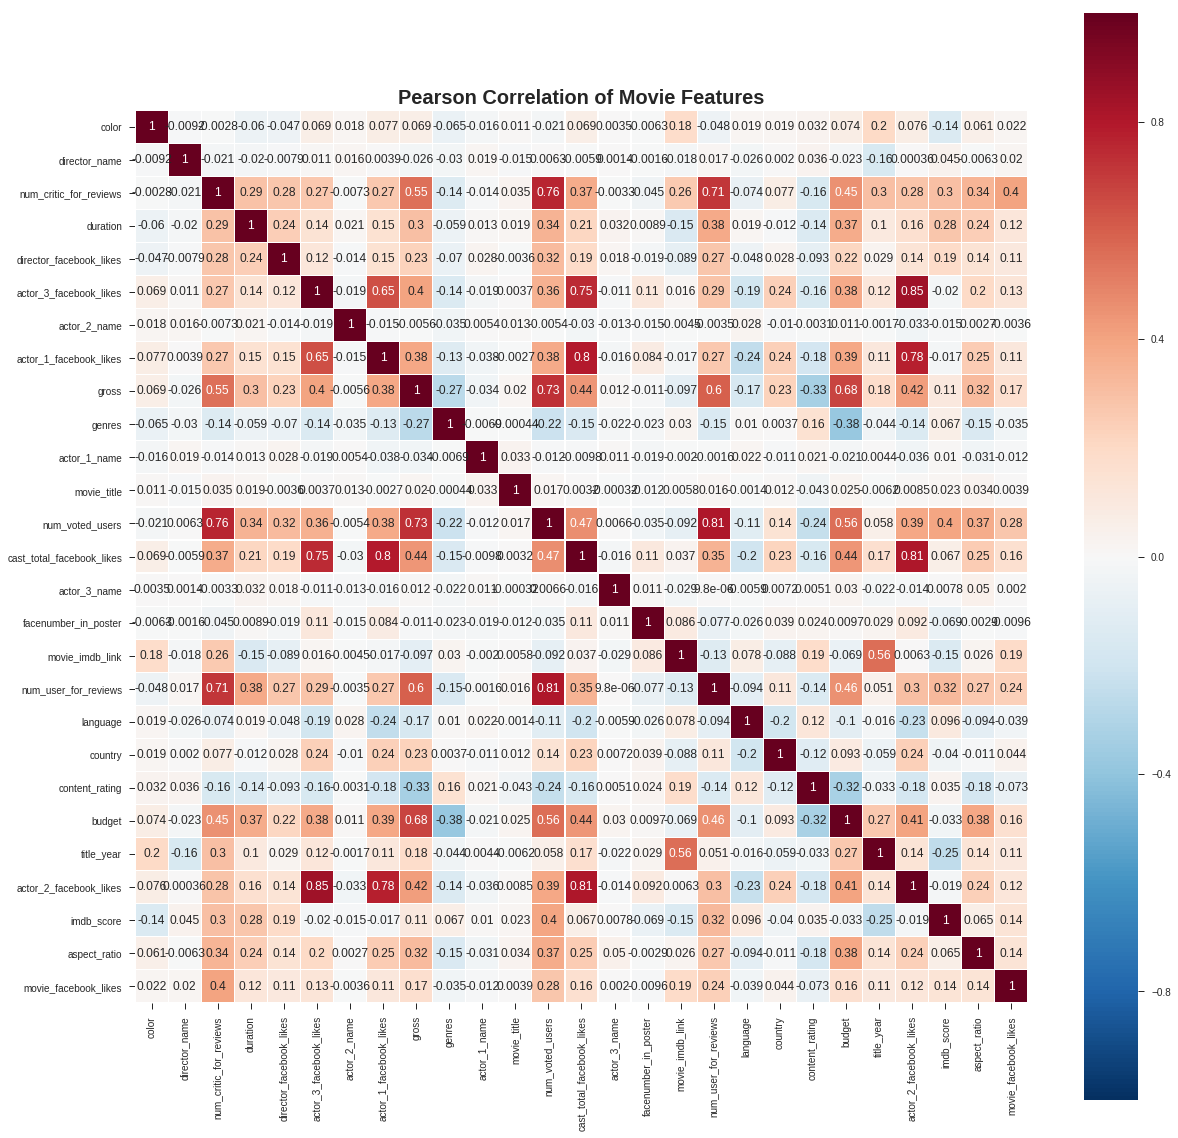

In [26]:
# Showing the pearson correlation of features
with sns.plotting_context(font_scale=1.25):
    f, ax = plt.subplots(figsize=(20, 20))
    plt.title('Pearson Correlation of Movie Features', {'weight': 'bold', 'size': 20})
    # plot_keywords features are encoded as array which requires more care to plot in this way
    new_dataframe = data_frame.drop('plot_keywords', axis=1)
    sns.heatmap(new_dataframe.astype(float).corr(), linewidths=0.25, vmax=1.0, square=True, annot=True)

In [36]:
data_frame.genres

0       106
1       100
2       127
3       287
4       753
5       125
6       119
7       307
8       125
9       446
10      125
11      125
12        1
13      100
14      129
15      106
16       90
17      125
18      100
19       36
20      452
21      100
22       71
23      452
24      442
25       78
26      846
27      125
28      126
29      126
       ... 
5013    768
5014    220
5015    605
5016    741
5017    696
5018    767
5019    890
5020    823
5021    638
5022    767
5023    905
5024    909
5025    587
5026    834
5027    767
5028    884
5029    747
5030    767
5031    686
5032    712
5033    855
5034    910
5035    202
5036    712
5037    605
5038    605
5039    735
5040    823
5041    638
5042    753
Name: genres, Length: 5043, dtype: object